<a href="https://colab.research.google.com/github/PedroPertusi/afd-monitor-jogadores/blob/main/data_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monitor de notícias de jogadores de futebol - Campeonato Brasileiro Série A 2025

## Objetivo do Notebook
Este notebook tem como objetivo extrair e analisar notícias de jogadores de futebol do Campeonato Brasileiro Série A 2025, coletando dados do site Globo Esporte e organizando-os em um formato estruturado para análise posterior.

## Bibliotecas e módulos
- **BeautifulSoup**: extração de conteúdo HTML
- **requests**: requisições HTTP
- **re**: expressões regulares para limpeza de texto
- **pandas**: manipulação e análise de dados

In [30]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd

Função para obter o HTML da página a ser acessada para extração dos dados

In [31]:
def baixar_pagina(url):
    """
    Faz uma requisição HTTP GET para a URL fornecida e retorna o conteúdo HTML da página.

    Parâmetros:
    url (str): Endereço da página a ser baixada.

    Retorna:
    str: Conteúdo HTML da página como texto decodificado em UTF-8.
    """
    response = requests.get(url)
    response.encoding = "utf-8"
    return response.text

Função responsável por obter o link de uma notícia contido em seu respectivo título

In [32]:
def extrair_links_noticias_post(url):
    """
    Extrai os links de notícias de um post de página HTML.

    Parâmetros:
    url (str): URL da página a partir da qual serão extraídos os links.

    Retorna:
    List[str]: Lista de URLs obtidas dos elementos <h2><a> encontrados na página.
    """
    html = baixar_pagina(url)
    soup = BeautifulSoup(html, 'html.parser')
    titulos = soup.find_all('h2')
    links_noticias = []
    for titulo in titulos:
        a_tag = titulo.find('a')
        if a_tag and a_tag.get('href'):
            links_noticias.append(a_tag.get('href'))
    return links_noticias


Função para extrair o conteúdo de cada notícia

In [33]:
def extrair_conteudo_noticia(url):
    """
    Extrai o conteúdo textual de uma notícia a partir da URL fornecida,
    filtrando parágrafos relevantes e descartando intertítulos e listas.

    Parâmetros:
    url (str): Endereço da página da notícia a ser processada.

    Retorna:
    List[str]: Lista de strings contendo o texto limpo de cada parágrafo
               (<p> com classe 'content-text__container') sem intertítulos
               (div com classe 'content-intertitle') nem listas (<ul>).
    """
    html = baixar_pagina(url)
    soup = BeautifulSoup(html, 'html.parser')
    ps = soup.find_all('p', class_='content-text__container')

    textos = []
    for p in ps:
        # descarta parágrafos que contenham intertítulo ou lista
        if p.find('div', class_='content-intertitle') or p.find('ul'):
            continue
        # extrai texto limpo (inclui <a>, <strong>, etc)
        textos.append(p.get_text(" ", strip=True))
    return textos

Após a definição das funções necessárias para a extração de dados, podemos aplicá-las para realizar a extração

O site escolhido para a obtenção de notícias foi o Globo Esporte (https://ge.globo.com/)

In [34]:
times = ["atletico-mg", "bahia", "botafogo", "bragantino", "ceara", "corinthians", "cruzeiro", "flamengo", "fluminense", "fortaleza",
         "gremio", "internacional", "juventude", "mirassol", "palmeiras", "santos", "sao-paulo", "sport", "vasco", "vitoria"]

conteudos_times = {}

In [35]:
base_url = "https://ge.globo.com/futebol/times/"

for t in times:
  time_url = base_url + t
  noticias = extrair_links_noticias_post(time_url)

  conteudos = []
  for n in noticias:
    if not n.startswith("https://ge.globo.com/"):
      continue
    conteudos.append(extrair_conteudo_noticia(n))

  pattern = re.compile(r'^\+ O ge')
  c = [" ".join(parts) for parts in conteudos if not pattern.match(" ".join(parts))]

  c = [i for i in c if i not in (" ", "")]

  conteudos_times[t] = c

In [36]:
records = [
    (time, noticia)
    for time, noticias in conteudos_times.items()
    for noticia in noticias
]

df_time_noticia = pd.DataFrame(records, columns=['time', 'noticia'])

Para verificarmos se a extração foi feita corretamente, vamos exibir o DataFrame construído com os times e suas respectivas notícias.

In [37]:
df_time_noticia

time                                            noticia
0   atletico-mg  Fala, galera! O time das Dicas Econômicas está...
1   atletico-mg  Atlético-MG e Cienciano entram em campo nesta ...
2   atletico-mg  O meia-atacante Bernard foi a grande novidade ...
3   atletico-mg  Antes de uma partida internacional, é normal o...
4         bahia  Durou dois minutos o sonho do Bahia em avançar...
..          ...                                                ...
84      vitoria  O site do Brasil Escola explica o "déjà-vu" co...
85      vitoria  Mesmo com superioridade numérica desde os 14 m...
86      vitoria  O Vitória sofreu mais um duro golpe na tempora...
87      vitoria  O Vitória foi eliminado da Copa Sul-Americana ...
88      vitoria  O Vitória alcançou o seu principal objetivo pa...

[89 rows x 2 columns]

Após a validação do DataFrame, podemos salvar estas informações dentro de um arquivo .csv

In [38]:
df_time_noticia.to_csv("times_noticias.csv")

## Conclusão
Neste notebook realizamos a extração de notícias de todos os times da Série A 2025, validamos o DataFrame resultante e salvamos os dados em um arquivo CSV para futuras análises.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leona\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


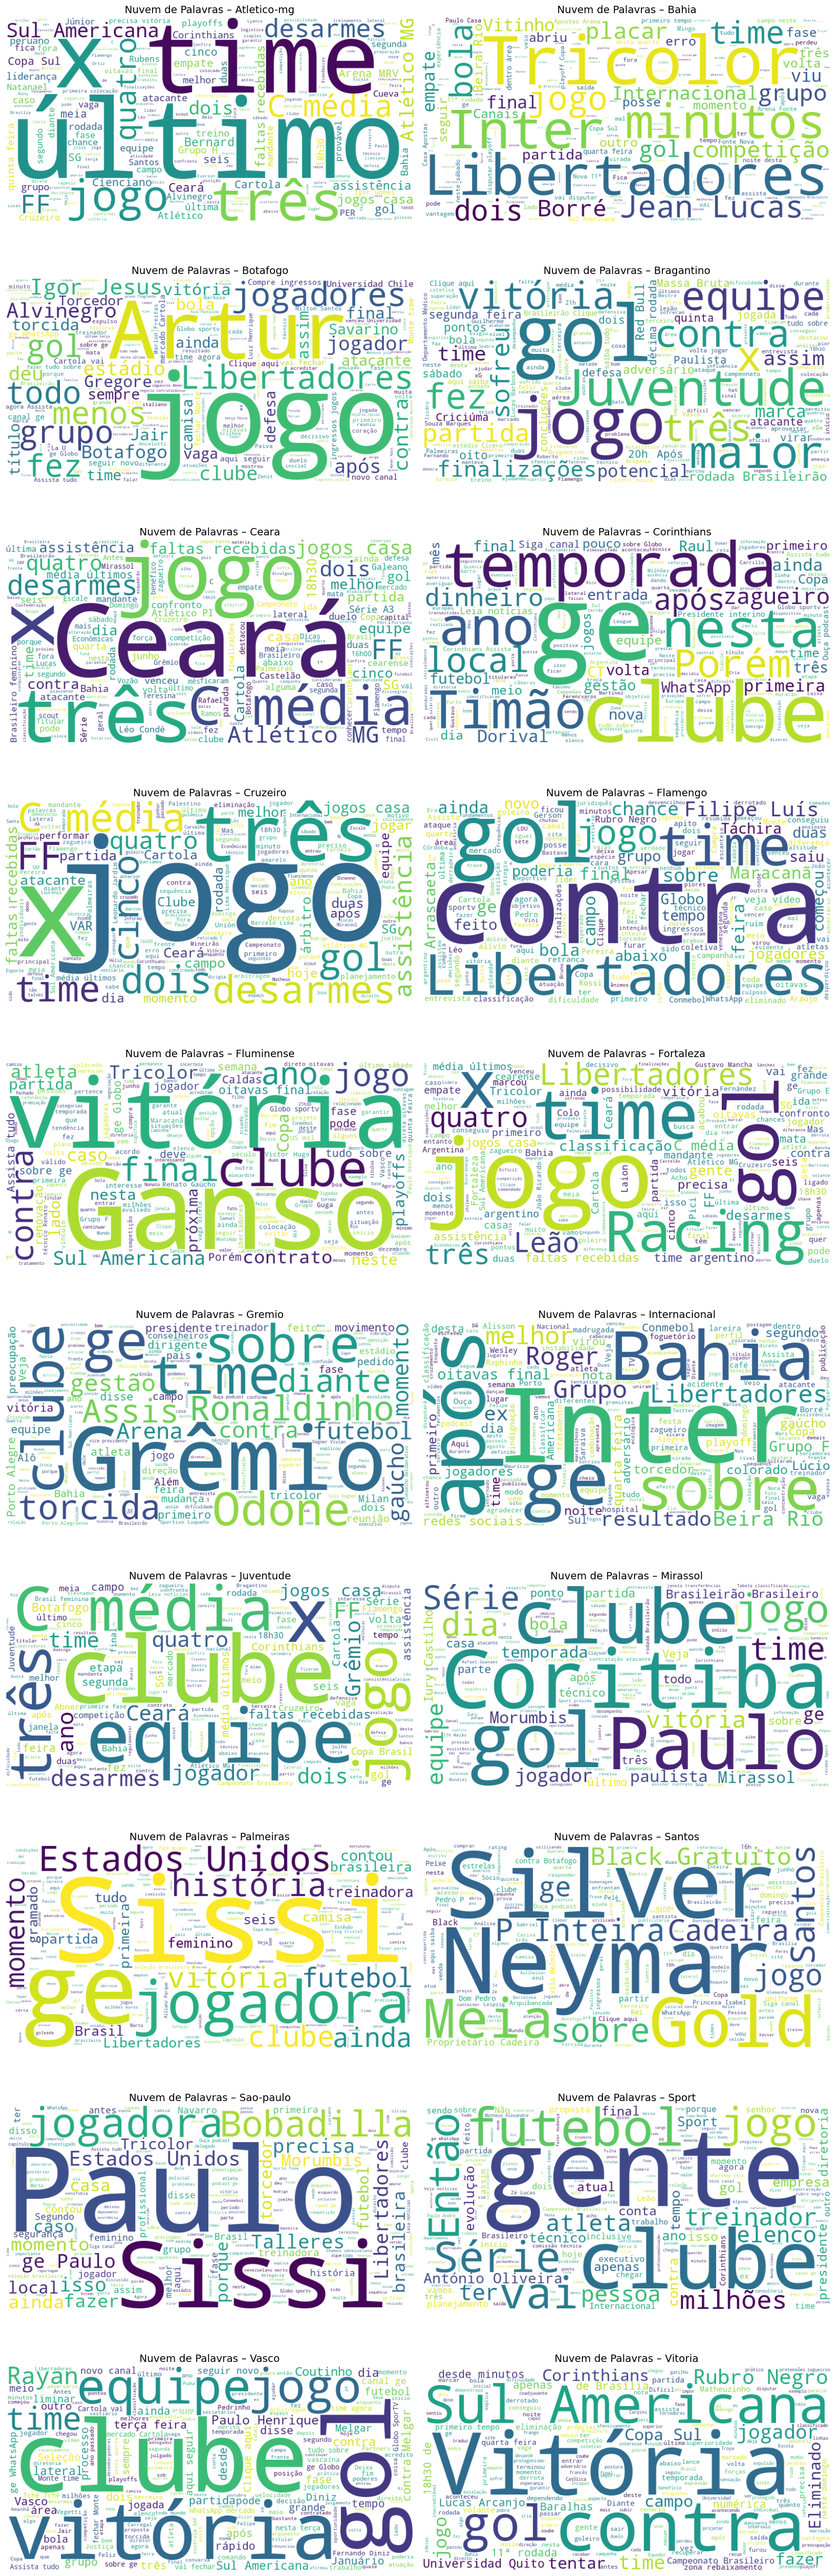

In [39]:
import math
import nltk
import wordcloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

nltk.download('stopwords')

def gerar_nuvens_por_time(conteudos_times):
    """
    Gera nuvens de palavras para cada time, plotando 2 nuvens por linha.
    """
    stop_words_base = set(stopwords.words('portuguese'))
    
    teams = list(conteudos_times.keys())
    n = len(teams)
    cols = 2
    rows = math.ceil(n / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5))
    axes = axes.flatten()

    for idx, time in enumerate(teams):
        texto = " ".join(conteudos_times[time])
        
        extras = {time, time.replace('-', ''), time.replace('-', ' ')}
        stop_words = stop_words_base.union(w.lower() for w in extras)
        
        palavras = [w for w in texto.split() if w.lower() not in stop_words]
        texto_limpo = " ".join(palavras)
        wc = wordcloud.WordCloud(width=800, height=400, background_color='white')\
             .generate(texto_limpo)
        
        ax = axes[idx]
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Nuvem de Palavras – {time.capitalize()}', fontsize=14)
    
    for j in range(n, rows * cols):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

gerar_nuvens_por_time(conteudos_times)
